In [1]:
# import stuff
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm
from sklearn import model_selection

import torch
import torch.utils.data as data
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function

import librosa

# Any results you write to the current directory are saved as output.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm
from torch.optim import lr_scheduler

import sklearn.metrics

In [2]:
os.makedirs("log", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [3]:
batch_size = 8
watermark = "resnet34"
model_name = watermark
CONTINUE = False

# define directories
base_dir = "./"
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

# load metadata
meta_data = pd.read_csv(meta_file)

# save train?
SAVE_DATA = True

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


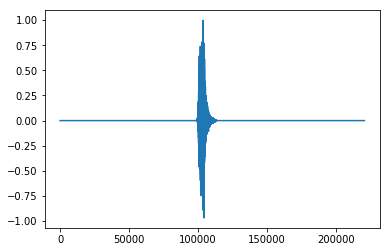

no display


In [4]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

# example data
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
try:
    show_melsp(melsp, fs)
except:
    print("no display")

# setup dataloaders

In [5]:
# define directories
base_dir = "./"
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

# load metadata
meta_data = pd.read_csv(meta_file)

In [6]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

In [7]:
class ESC50Dataset(Dataset):
    def __init__(self, data, label, data_aug=False, _type='train'):
        self.label = label
        self.data_aug = data_aug
        self.data = data
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,idx):
        label = self.label[idx]
        x, fs = load_wave_data(audio_dir, self.data[idx])
        
        # augumentations in wave domain.
        if self.data_aug:
            r = np.random.rand()
            if r < 0.3:
                x = add_white_noise(x)

            r = np.random.rand()
            if r < 0.3:
                x = shift_sound(x, rate=1+np.random.rand())

            r = np.random.rand()
            if r < 0.3:
                x = stretch_sound(x, rate=0.8+np.random.rand()*0.4)
        
        # convert to melsp
        melsp = calculate_melsp(x)
        
        # normalize
        mean = np.mean(melsp)
        std = np.std(melsp)
        
        melsp -= mean
        melsp /= std
        
        melsp = np.asarray([melsp, melsp, melsp])
        return melsp, label

In [8]:
# get training dataset and target dataset
x = list(meta_data.loc[:,"filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


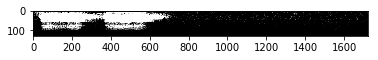

In [9]:
traindataset = ESC50Dataset(x_train, y_train, data_aug=True)
testdataset = ESC50Dataset(x_test, y_test, data_aug=False)
train_loader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size,shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size,shuffle=True, num_workers=8)

mel, label = traindataset[0]
plt.imshow(mel.transpose([1,2,0]))

# setup model

In [10]:
# backbone
import pretrainedmodels
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
basemodel = nn.Sequential(*list(basemodel.children())[:-2])

In [11]:
class mymodel(nn.Module):
    def __init__(self):
        super(mymodel, self).__init__()
        self.features = basemodel
        if model_name == "resnet34" or model_name == "resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        self.fc = nn.Conv2d(num_ch, 50, 1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.fc(x).squeeze(2).squeeze(2)
        return x

In [12]:
model = mymodel()
input = torch.rand([1,3,128,128])
model(input).size()

torch.Size([1, 50])

# optimizers

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mymodel().to(device)
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 100 # original 50

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True, min_lr=1e-3*1e-4, factor=0.33)

# train loop

In [14]:
def train(epoch):
    model.train()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc = 0.0

    t = tqdm(train_loader)
    
    for idx, (inputs,labels) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels = labels.to(device)
     
        # set opt
        optimizer.zero_grad()
        
        # run model
        outputs = model(inputs.float())
            
        loss = criterion(outputs,labels)
        # misc
        running_loss += loss
        running_acc += (outputs.argmax(1)==labels).float().mean()
        acc += (outputs.argmax(1)==labels).float().mean()
        loss.backward()
        optimizer.step()
        
        t.set_description(f't (l={running_loss/(idx+1):.4f})(a1={acc/(idx+1):.4f})')
        if idx%8==7:
            rd = np.random.rand()
        
    #scheduler.step()
    losses.append(running_loss/len(train_loader))
    accs.append(running_acc/(len(train_loader)))
    print('train acc : {:.2f}%'.format(running_acc/(len(train_loader))))
    print('train loss : {:.4f}'.format(running_loss/len(train_loader)))
    print('dev acc1 : {:.2f}%'.format(acc/(len(train_loader))))
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                     'loss': running_loss/len(train_loader), "acc1": acc/(len(train_loader))}
    logs.append(log_epoch)
    df = pd.DataFrame(logs)
    df.to_csv("log/log_output_train_{}.csv".format(watermark))
    

In [15]:
def eval(epoch):
    model.eval()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc = 0.0

    t = tqdm(test_loader)
    
    for idx, (inputs,labels) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels = labels.to(device)
     
        # set opt
        optimizer.zero_grad()
        
        with torch.no_grad():
            # run model
            outputs = model(inputs.float())
            
        loss = criterion(outputs,labels)
        # misc
        running_loss += loss
        running_acc += (outputs.argmax(1)==labels).float().mean()
        acc += (outputs.argmax(1)==labels).float().mean()
        #loss.backward()
        #optimizer.step()
        
        t.set_description(f't (l={running_loss/(idx+1):.4f})(a1={acc/(idx+1):.4f})')
        if idx%8==7:
            rd = np.random.rand()
        
    #scheduler.step()
    losses.append(running_loss/len(test_loader))
    accs.append(running_acc/(len(test_loader)))
    print('eval acc : {:.2f}%'.format(running_acc/(len(test_loader))))
    print('eval loss : {:.4f}'.format(running_loss/len(test_loader)))
    print('dev acc1 : {:.2f}%'.format(acc/(len(test_loader))))
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                     'loss': running_loss/len(test_loader), "acc1": acc/(len(test_loader))}
    logs_eval.append(log_epoch)
    df = pd.DataFrame(logs_eval)
    df.to_csv("log/log_output_eval_{}.csv".format(watermark))
    

In [ ]:
import gc
logs = []
logs_eval = []
losses = []
accs = []
logs = []
start = 0
epochs = 100

if CONTINUE:
    #start = START
    model.load_state_dict(torch.load("./models/cutonly_se_resnext50_32x4d_cutmix_236_29epochs_saved_weights.pth"))

for epoch in range(start, epochs):
    torch.cuda.empty_cache()
    train(epoch)
    torch.cuda.empty_cache()
    eval(epoch)
    if epoch %10==0:
        torch.save(model.state_dict(), './models/{}_{}epochs_saved_weights.pth'.format(watermark, epoch))
    # GC
    torch.cuda.empty_cache()
    gc.collect()
    

epochs 1/100 


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



train acc : 0.31%
train loss : 2.7548
dev acc1 : 0.31%
epochs 1/100 


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



eval acc : 0.53%
eval loss : 1.6876
dev acc1 : 0.53%
epochs 2/100 



train acc : 0.61%
train loss : 1.5695
dev acc1 : 0.61%
epochs 2/100 



eval acc : 0.67%
eval loss : 1.1449
dev acc1 : 0.67%
epochs 3/100 



train acc : 0.74%
train loss : 1.1085
dev acc1 : 0.74%
epochs 3/100 



eval acc : 0.73%
eval loss : 0.9219
dev acc1 : 0.73%
epochs 4/100 



train acc : 0.82%
train loss : 0.7636
dev acc1 : 0.82%
epochs 4/100 



eval acc : 0.79%
eval loss : 0.7815
dev acc1 : 0.79%
epochs 5/100 



train acc : 0.85%
train loss : 0.6370
dev acc1 : 0.85%
epochs 5/100 



eval acc : 0.84%
eval loss : 0.5792
dev acc1 : 0.84%
epochs 6/100 
